# 🖼️ CIFAR-10 Classification with VGG16 and VGG18 Models

In this notebook, we use **VGG16** and **VGG18** models to classify images in the **CIFAR-10** dataset. We load and preprocess the data, define the model architectures, train the models, and evaluate their performance using a classification matrix to assess accuracy per class. Let's dive into deep learning with VGG architectures! 🚀

In [1]:

# Import required libraries 📚
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


### Data Loading and Preprocessing 📦

We load the **CIFAR-10** dataset and apply data augmentations, including random cropping and horizontal flipping for the training set, to improve generalization. The images are also normalized to improve model training.

In [2]:

# Define transformations with data augmentation for the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 data with the specified transformations
batch_size = 64
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# CIFAR-10 classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [00:03<00:00, 43778065.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:

# Define VGG-like architecture
class VGGNet(nn.Module):
    def __init__(self, vgg_type, num_classes=10):
        """Initializes VGGNet model with either VGG16 or VGG18 architecture."""
        super(VGGNet, self).__init__()
        if vgg_type == 'VGG16':
            layers = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        elif vgg_type == 'VGG18':
            layers = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

        self.features = self._make_layers(layers)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, layers):
        """Helper function to create VGG layers based on specified architecture."""
        net_layers = []
        in_channels = 3
        for layer in layers:
            if layer == 'M':
                net_layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                net_layers += [
                    nn.Conv2d(in_channels, layer, kernel_size=3, padding=1),
                    nn.BatchNorm2d(layer),
                    nn.ReLU(inplace=True)
                ]
                in_channels = layer
        return nn.Sequential(*net_layers)

# Instantiate VGG16 and VGG18 models
vgg16_model = VGGNet('VGG16').to(device)
vgg18_model = VGGNet('VGG18').to(device)


In [4]:

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    """Trains the model on the training dataset for a specified number of epochs."""
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    return model

# Evaluation function
def evaluate_model(model, test_loader):
    """Evaluates the model on the test dataset and returns true and predicted labels."""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds


In [5]:

# Train and evaluate VGG16
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(vgg16_model.parameters(), lr=0.001, weight_decay=0.0005)
print("Training VGG16...")
vgg16_model = train_model(vgg16_model, train_loader, criterion, optimizer_vgg16, num_epochs=num_epochs)

# Train and evaluate VGG18
optimizer_vgg18 = optim.Adam(vgg18_model.parameters(), lr=0.001, weight_decay=0.0005)
print("Training VGG18...")
vgg18_model = train_model(vgg18_model, train_loader, criterion, optimizer_vgg18, num_epochs=num_epochs)

# Evaluate and get predictions
y_true_vgg16, y_pred_vgg16 = evaluate_model(vgg16_model, test_loader)
y_true_vgg18, y_pred_vgg18 = evaluate_model(vgg18_model, test_loader)


Training VGG16...
Epoch [1/10], Loss: 1.7463
Epoch [2/10], Loss: 1.2172
Epoch [3/10], Loss: 1.0037
Epoch [4/10], Loss: 0.8696
Epoch [5/10], Loss: 0.7670
Epoch [6/10], Loss: 0.6862
Epoch [7/10], Loss: 0.6179
Epoch [8/10], Loss: 0.5800
Epoch [9/10], Loss: 0.5451
Epoch [10/10], Loss: 0.5204
Training VGG18...
Epoch [1/10], Loss: 1.4445
Epoch [2/10], Loss: 1.0084
Epoch [3/10], Loss: 0.8333
Epoch [4/10], Loss: 0.7349
Epoch [5/10], Loss: 0.6644
Epoch [6/10], Loss: 0.6052
Epoch [7/10], Loss: 0.5574
Epoch [8/10], Loss: 0.5229
Epoch [9/10], Loss: 0.4969
Epoch [10/10], Loss: 0.4733


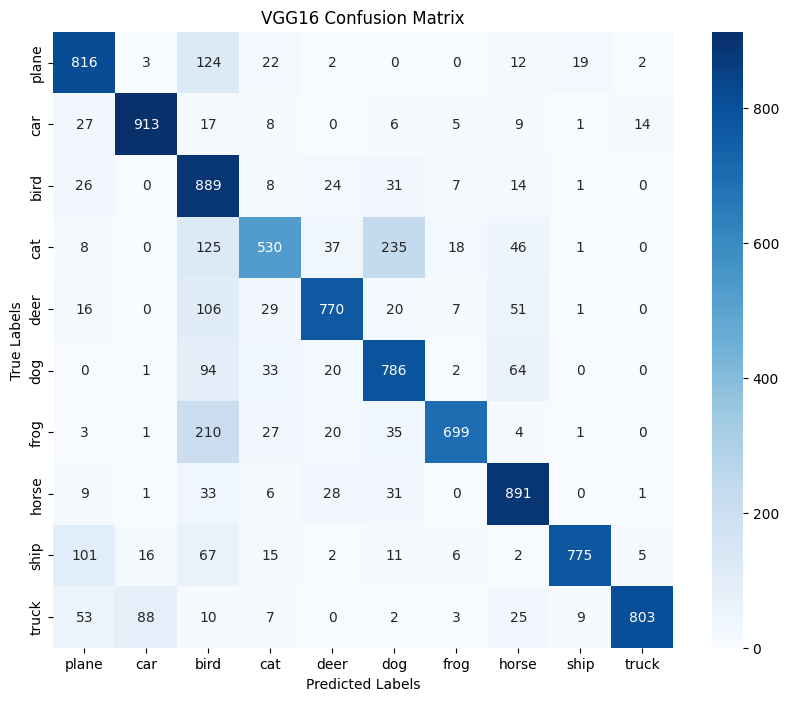

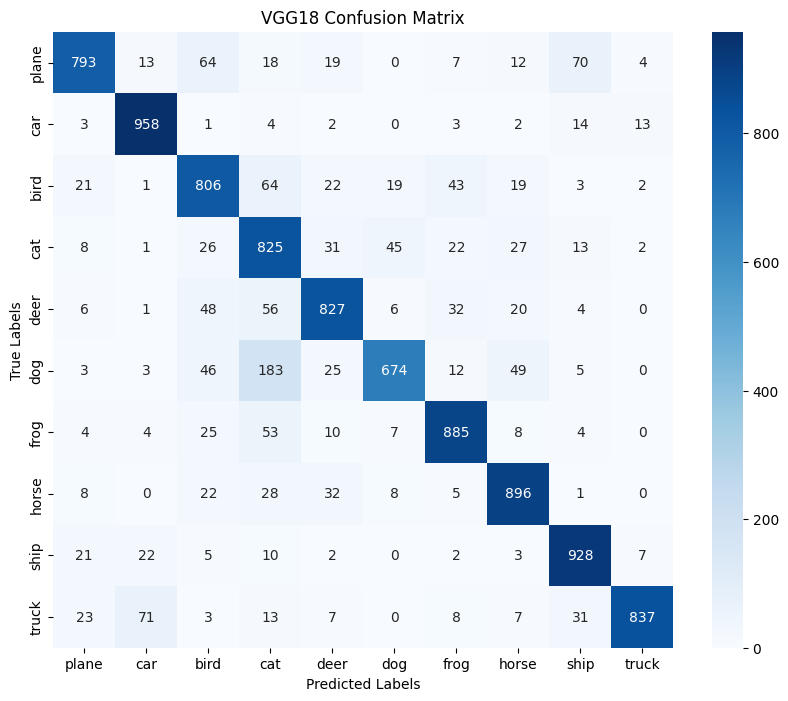

In [6]:

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title(title)
    plt.show()

# Plot confusion matrices for VGG16 and VGG18
plot_confusion_matrix(y_true_vgg16, y_pred_vgg16, classes, title="VGG16 Confusion Matrix")
plot_confusion_matrix(y_true_vgg18, y_pred_vgg18, classes, title="VGG18 Confusion Matrix")
